In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
import matplotlib.pyplot as plt
import skimage
import imageio
import math
import face_alignment
import numpy as np
import matplotlib.patches as mpatches
from IPython.display import Video

import os
import yaml
from tqdm import tqdm

from skimage.transform import resize
from skimage import img_as_ubyte
import torch
from sync_batchnorm import DataParallelWithCallback

from modules.generator import OcclusionAwareGenerator
from modules.keypoint_detector import KPDetector
from animate import normalize_kp
from scipy.spatial import ConvexHull


%matplotlib inline


In [28]:
def plot_images(images, bboxes=None, titles=None):
    fig = plt.figure(figsize=(15, 15))
    n_row = 4
    n_col = math.ceil(len(images) / n_row)
    for i, im in enumerate(images):
        ax = plt.subplot(n_col, n_row, i+1)
        ax.imshow(im)
        if titles is not None:
            ax.set_title(titles[i])
        if bboxes is not None:
            (x1, y1, x2, y2) = bboxes[i].flatten()
            rect = mpatches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
    plt.show()

# Quellen

- Siarohin, A & Lathuilière, S & Tulyakov, S & Ricci, E & Sebe, N 2019 'First Order Motion Model for Image Animation', _Conference on Neural Information Processing Systems (NeurIPS)_, Dezember, 2019

- Bulat, A & Tzimiropoulos, G 2017 'How far are we from solving the 2D & 3D Face Alignment problem? (and a dataset of 230,000 3D facial landmarks', _International Conference on Computer Vision_, 2017

# Ziel

TODO: Beschreiben, was das eigentliche Ziel ist

# Data Preprocessing
In einem ersten Schritt müssen wir unsere Daten vorbereiten. Dazu zählt das Video sowie das zu animierende Bild.

### Video

Ein Video besteht aus mehreren Frames:

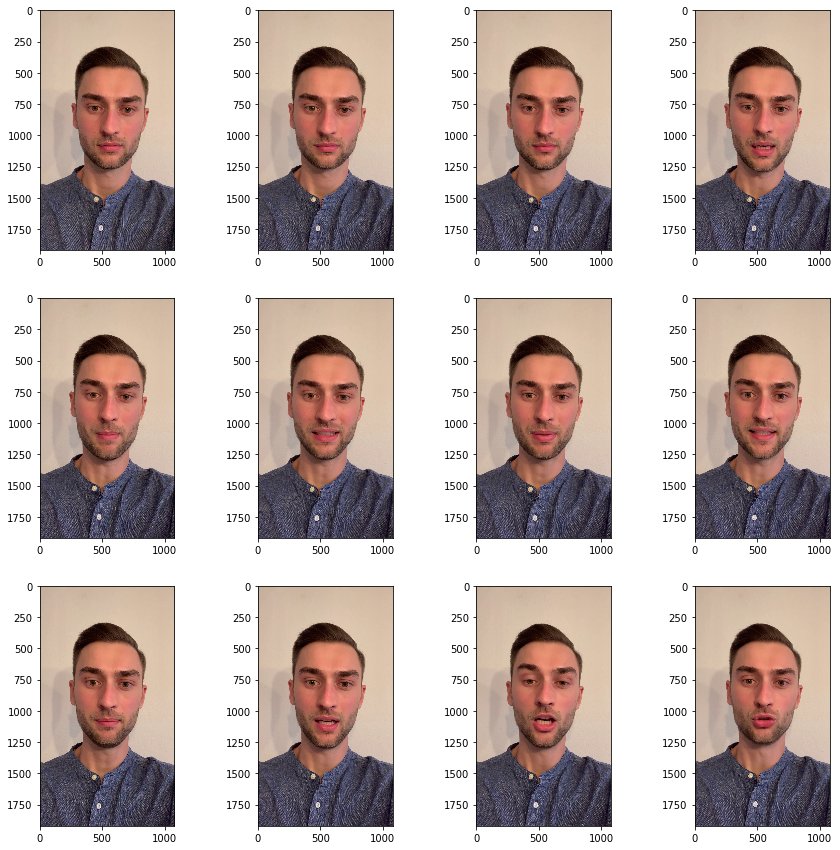

In [29]:
path_video = "data/driver.mp4"
video = imageio.get_reader(path_video)

frames = [f for f in video]
first_frames = [frames[i] for i in range(0,84,7)]
plot_images(first_frames)

### Bounding Boxes

Für unser Fake-Video konzentrieren wir uns nur auf das Gesicht. Daher wollen wir das Video entsprechend zuschneiden.
Wir suchen in den einzelnen Frames nach dem Gesicht und zeichnen eine Bounding Box darum:

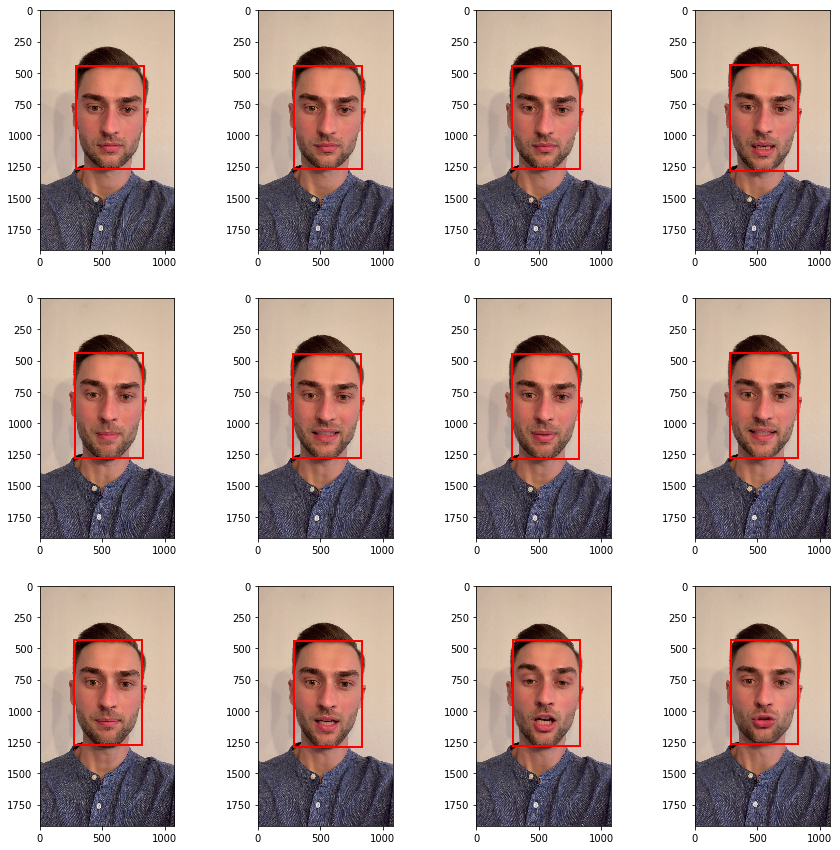

In [30]:
device = 'cpu'
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device=device)

def extract_bbox(frame, fa):
    if max(frame.shape[0], frame.shape[1]) > 640:
        scale_factor =  max(frame.shape[0], frame.shape[1]) / 640.0
        frame = resize(frame, (int(frame.shape[0] / scale_factor), int(frame.shape[1] / scale_factor)))
        frame = img_as_ubyte(frame)
    else:
        scale_factor = 1
    frame = frame[..., :3]
    bboxes = fa.face_detector.detect_from_image(frame[..., ::-1])
    if len(bboxes) == 0:
        return []
    return np.array(bboxes)[:, :-1] * scale_factor

bboxes = []
for frame in first_frames:
    bboxes.append(extract_bbox(frame, fa))
plot_images(first_frames, bboxes)

Jedes Frame hat die Bounding Box an einer anderen Position. Deshalb berechnen wir Rechteck, welches alle Bounding Boxen umschliesst:

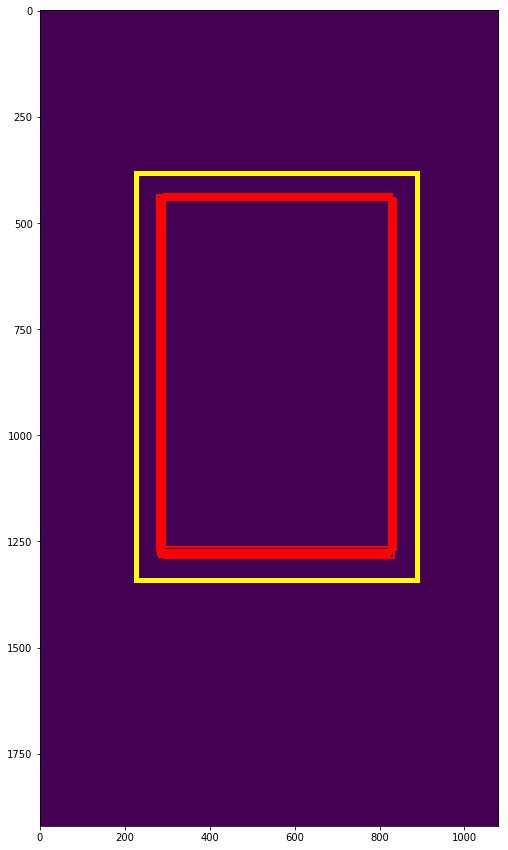

In [31]:
x, y = [], []
tol = 50
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np.ones((1920, 1080)))
for bbox in bboxes:
    (x1, y1, x2, y2) = bbox.flatten()
    ax.add_patch(mpatches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
    x.append(x1), x.append(x2), y.append(y1), y.append(y2)
ax.add_patch(mpatches.Rectangle((np.min(x)-tol, np.min(y)-tol), np.max(x)-np.min(x)+2*tol, np.max(y)-np.min(y)+2*tol, fill=False, edgecolor='yellow', linewidth=5))
plt.show()

In [32]:
driv_video = "crop.mp4"
img = "data/parmelin.jpg"

### Video zuschneiden

Nachdem wir die Bounding-Boxen für jedes Frame gefunden haben, schneiden wir das Video entsprechend zu. Damit es schneller geht, verkleinern wir die Frames. Zusätzlich verändern wir die Grösse von jedem Frame, so dass diese der Grösse unseres Bildes entsprechen:

In [33]:
!python ../crop-video.py --inp data/driver.mp4 --cpu

/Users/pascal/opt/anaconda3/envs/first-order-model/lib/python3.7/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
189it [06:35,  2.09s/it]
ffmpeg -i data/driver.mp4 -ss 0.0 -t 6.2729396062729395 -filter:v "crop=1072:1074:0:315, scale=256:256" crop.mp4
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 9.0.1
  configuration: --prefix=/Users/pascal/opt/anaconda3/envs/first-order-model --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 

In [34]:
Video(driv_video)

### Bild laden

Neben dem Video benötigen wir auch ein Bild von Guy Parmelin

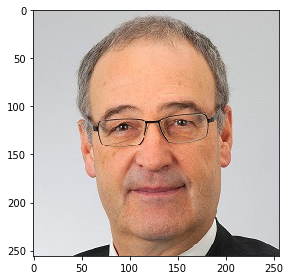

In [35]:
skimage.io.imshow(img)

# Deep Fake

Nachdem die Daten vorbereitet sind, können wir nun unser Fake Video erzeugen. Dies funktioniert mit zwei Modulen


1. Modul zur Schätzung der Bewegung
2. Modul zur Bilderzeugung


### Modul zur Bewegungsabschätzung
- Ein neuronales Netzwerk lernt in Bildern Schlüsselpunkte zu erkennen. Wenn die Schlüsselpunkte aus den einzelnen Videoframes verglichen werden, können die Bewegungen abgeschätzt werden

![Keypoints](data/keypoints.png)

- Die Bewegungen werden dann kodiert an das Modul zur Bilderzeugung übergeben


### Modul zur Bilderzeugung

- Das zweite Modul erzeugt das Bild. Dazu schätzt es ab, welche Bewegungen durch Verzerren des Bildes bewirkt werden können und wo das Bild "übermalt" werden soll

<img src="data/keypoints_gen.png" alt="Keypoints" width="300"/>


- Anschliessend werden die angepassten Bilder wieder zu einem Video zusammengefügt

<br>
<br>
<br>


### Training

Ein neuronales Netzwerk erlernt wie es diese Aufgaben vollautomatisch erfüllen kann. Dieses Erlernen erfordert jedoch viel Rechenleistung und dauert lange.

Deshalb verwenden wir in unserem Beispiel ein bereits trainiertes Netzwerk:

In [36]:
def load_checkpoints(config_path, checkpoint_path, cpu=True):

    with open(config_path) as f:
        config = yaml.load(f)

    generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
    if not cpu:
        generator.cuda()

    kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                             **config['model_params']['common_params'])
    if not cpu:
        kp_detector.cuda()
    
    if cpu:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint_path)
 
    generator.load_state_dict(checkpoint['generator'])
    kp_detector.load_state_dict(checkpoint['kp_detector'])
    
    if not cpu:
        generator = DataParallelWithCallback(generator)
        kp_detector = DataParallelWithCallback(kp_detector)

    generator.eval()
    kp_detector.eval()
    
    return generator, kp_detector

Das neuronale Netzwerk sucht zuerst die Schlüsselpunkte im Bild und danach im Video. Anhand dieser Daten wird dann das neue Video erzeugt: 

In [37]:
def make_animation(source_image, driving_video, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=True):
    with torch.no_grad():
        predictions = []
        source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source = source.cuda()
        driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)
        kp_source = kp_detector(source)
        kp_driving_initial = kp_detector(driving[:, :, 0])

        for frame_idx in tqdm(range(driving.shape[2])):
            driving_frame = driving[:, :, frame_idx]
            if not cpu:
                driving_frame = driving_frame.cuda()
            kp_driving = kp_detector(driving_frame)
            kp_norm = normalize_kp(kp_source=kp_source, kp_driving=kp_driving,
                                   kp_driving_initial=kp_driving_initial, use_relative_movement=relative,
                                   use_relative_jacobian=relative, adapt_movement_scale=adapt_movement_scale)
            out = generator(source, kp_source=kp_source, kp_driving=kp_norm)

            predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
    return predictions

Damit das Resultat noch realistischer aussieht verwenden wir einen Trick. Anstatt dass wir das Video am Anfang starten durchsuchen wir das gesamte Video nach einem Frame, dass am ehesten dem Bild von Herrn Parmelin entspricht. Danach generieren wir das Video von diesem Frame aus je einmal vorwärts und einmal rückwärts. Am Ende setzen wir dann das generierte Video wieder in der korrekten Reihenfolge zusammen:

In [40]:
def find_best_frames(source, driving, n_frames=20, cpu=True):

    def normalize_kp(kp):
        kp = kp - kp.mean(axis=0, keepdims=True)
        area = ConvexHull(kp[:, :2]).volume
        area = np.sqrt(area)
        kp[:, :2] = kp[:, :2] / area
        return kp

    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=True, device='cpu' if cpu else 'cuda')
    kp_source = fa.get_landmarks(255 * source)[0]
    kp_source = normalize_kp(kp_source)

    frame_norm = {}
    for i, image in tqdm(enumerate(driving)):
        kp_driving = fa.get_landmarks(255 * image)[0]
        kp_driving = normalize_kp(kp_driving)
        f_norm = (np.abs(kp_source - kp_driving) ** 2).sum()
        frame_norm[i] = f_norm
    sorted_frame_norm = dict(reversed(sorted(frame_norm.items(), key=lambda kv: kv[1])))
    best_frames = list(sorted_frame_norm.keys())[:n_frames]
    return fa, best_frames

Anstatt das erste Frame (mitte) verwenden wir nun also das für den Algorithmus "beste" Frame (rechts) um die Bewegungen zu berechnen:

188it [07:10,  2.29s/it]


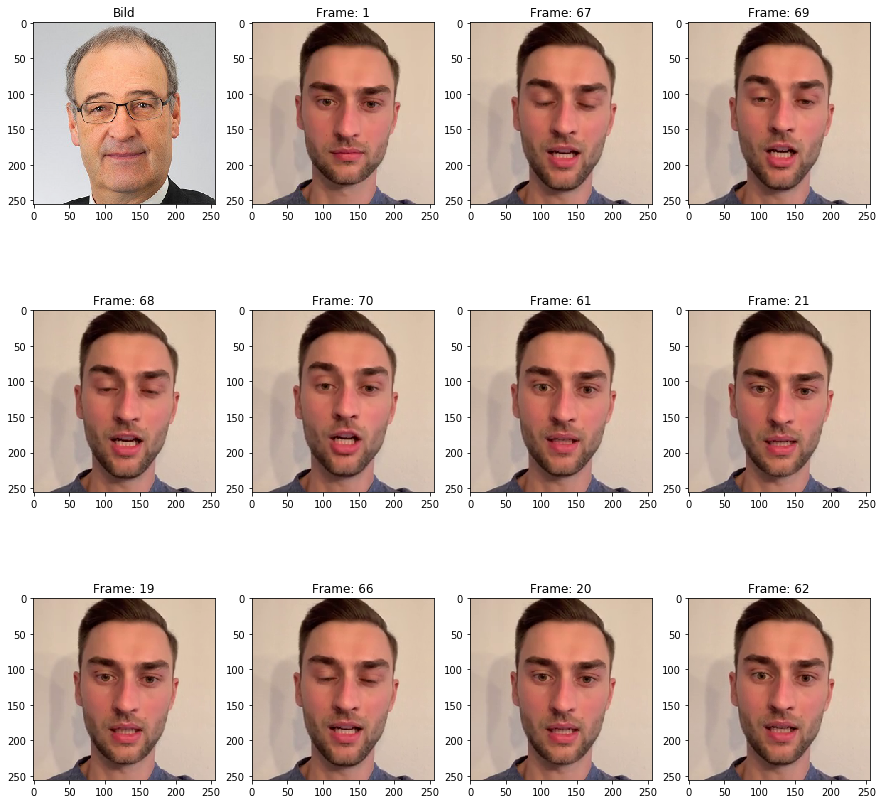

In [41]:
source_image = imageio.imread(img)
reader = imageio.get_reader(driv_video)
driving_video = [f for f in reader]
source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

fa, best_frames = find_best_frames(source_image, driving_video)

images, titles = [], []
images.append(source_image)
titles.append("Bild")
images.append(driving_video[0])
titles.append("Frame: {}".format(0))

for f in best_frames:
    images.append(driving_video[f])
    titles.append("Frame: {}".format(f))

plot_images(images, titles=titles)

Nun müssen wir diese Module nur noch zusammensetzen und ausführen.

In [42]:
fps = reader.get_meta_data()['fps']
config = "../config/vox-adv-256.yaml"
checkpoint = "../checkpoints/vox-adv-cpk.pth.tar"
result = "result.mp4"
cpu = True


generator, kp_detector = load_checkpoints(config_path=config, checkpoint_path=checkpoint, cpu=cpu)

i = 0  # TODO =best_frame
driving_forward = driving_video[i:]
driving_backward = driving_video[:(i+1)][::-1]
predictions_forward = make_animation(source_image, driving_forward, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=cpu)
predictions_backward = make_animation(source_image, driving_backward, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=cpu)
predictions = predictions_backward[::-1] + predictions_forward[1:]
imageio.mimsave(result, [img_as_ubyte(frame) for frame in predictions], fps=fps)

100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


### Videos zusammenfügen

Damit wir das Resultat besser sehen, fügen wir das originale sowie das erzeugte Video zusammen.

In [43]:
os.system("ffmpeg -i crop.mp4 -i result.mp4 -filter_complex hstack finished_video.mp4")

0

### Resultat

In [44]:
os.system("ffmpeg -i crop.mp4 -i result.mp4 -filter_complex hstack finished_video.mp4")

256

### Resultat

In [45]:
Video("finished_video.mp4")

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Weitere Möglichkeiten

### Verschiedene Annimationen:

![Screenshot](../sup-mat/vox-teaser.gif)

![Screenshot](../sup-mat/fashion-teaser.gif)

![Screenshot](../sup-mat/mgif-teaser.gif)


### Face Swap

![Screenshot](../sup-mat/face-swap.gif)